In [22]:
#test SRBF function
%reload_ext autoreload
%autoreload 2
from ReadData import ReadCurrentAndField_CNN,add_gaussian_noise
import glob


import numpy as np
import torch
import os
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
train_file_num= 100
#data = ReadFolder(foldername,filepattern)
current,data = ReadCurrentAndField_CNN (foldername,filepattern,train_file_num)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:3,2:19:2,2:19:2,2:19:2]
Bfield = data[:,3:,2:19:2,2:19:2,2:19:2]
noise = 0.05
grid_size=position.shape[2]
# print(fileList)
print(data.shape)
print('current shape', current.shape)
print('Bfield shape', Bfield.shape)
print('train:gird :',grid_size)
# current = add_gaussian_noise(current,noise=noise)
# Bfield = add_gaussian_noise(Bfield,noise=noise)


Good to go
torch.Size([100, 6, 21, 21, 21])
current shape torch.Size([100, 12])
Bfield shape torch.Size([100, 3, 9, 9, 9])
train:gird : 9


max tensor(0.0234)
max tensor(-0.0189)
tensor([0.7500, 0.7500, 0.7500])
torch.Size([3, 16, 16, 16])


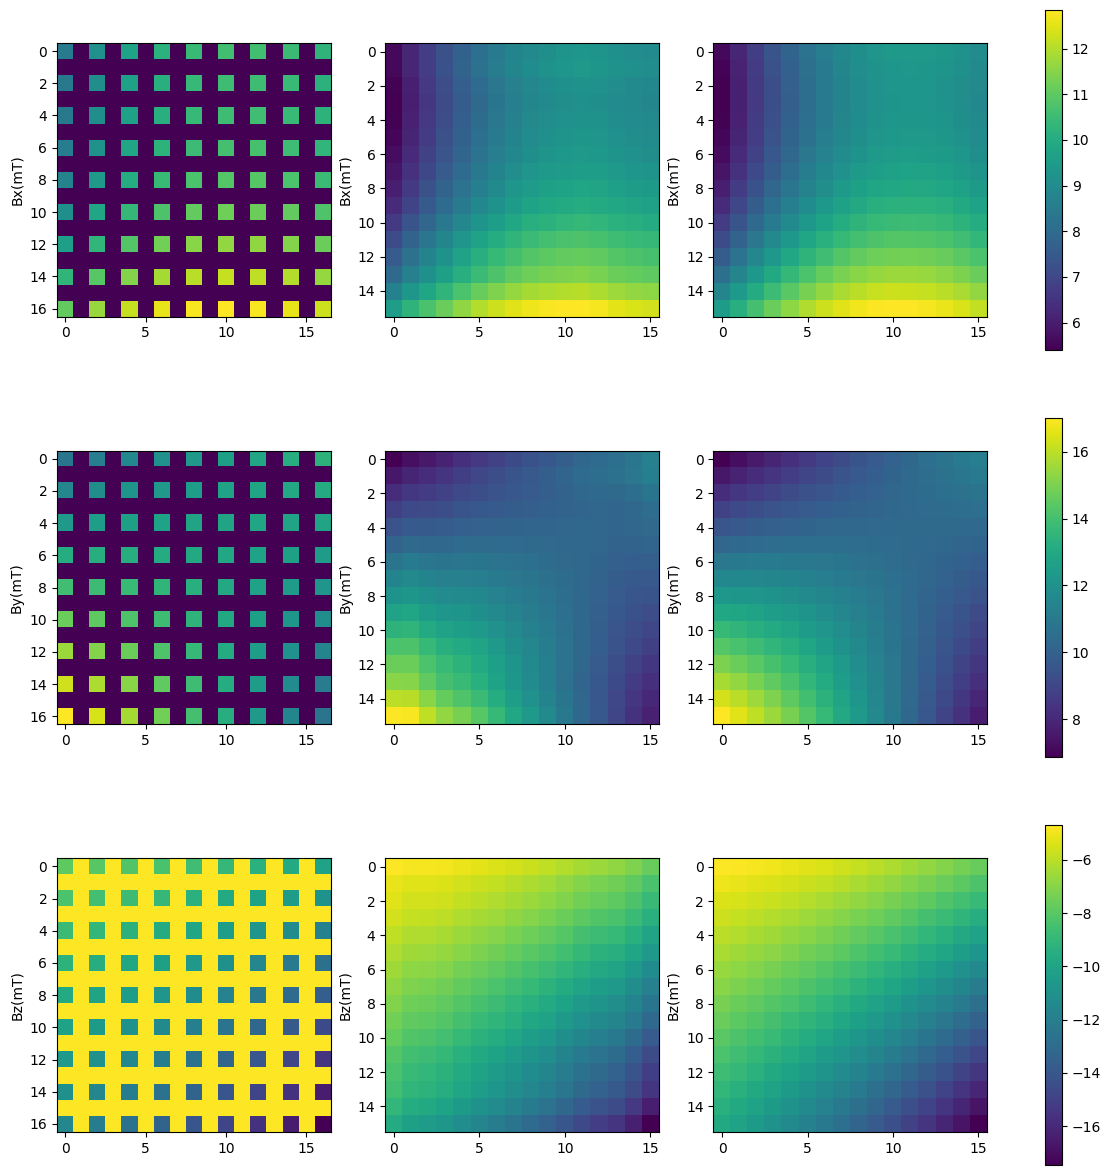

In [30]:
from SRBF import SRBF_interpolation,gridData_reshape,Euclidean_distance
import matplotlib.pyplot as plt
import random
from random import randint
from utils import denorm
sample_index = randint(0,train_file_num-1)
centers_p = position[sample_index,:,:,:,:]/0.04
centers_y = Bfield[sample_index,:,:,:,:]

print('max',centers_y.max())
print('max',centers_y.min())

print(centers_p[:,7,7,7])

maxb=centers_y.max()
minb=centers_y.min()

centers_y_norm=2*((centers_y-minb)/(maxb-minb))-1
eps=6

samples_p = data[sample_index,0:3,2:18,2:18,2:18]/0.04
samples_y = data[sample_index,3:,2:18,2:18,2:18]
gird_interp=samples_p.shape[2]
samples_y_norm=2*((samples_y-minb)/(maxb-minb))-1
# print(samples_p.shape)

RBF= SRBF_interpolation(eps)
weight,phi_temp= RBF.fit(centers_p, centers_y_norm,device=device)
samples_y_interp_norm=RBF(samples_p,device=device).reshape(gird_interp,gird_interp,gird_interp,3).permute(3,0,1,2)

print(samples_y_interp_norm.shape)
samples_y_interp=denorm(samples_y_interp_norm, maxb, minb,device=device)
ylables=['Bx(mT)','By(mT)','Bz(mT)']



B=torch.zeros(3,17,17,17)



for i in range(0,9):
    for j in range(0,9):
        for k in range(0,9):
            B[:,2*i,2*j,2*k]=centers_y[:,i,j,k]




z_plane_index=8
f = plt.figure(figsize=(15,15))
for i in range(0,3):

    B_exp_temp =B[i,:,:,z_plane_index]*1e3
    ax = f.add_subplot(3,3,3*i+1)
    img_plot = ax.imshow( B_exp_temp.cpu() )    
    plt.ylabel(ylables[i])
    


    B_est_temp =samples_y_interp[i,:,:,z_plane_index]*1e3
    ax1 = f.add_subplot(3,3,3*i+2)
    img_plot = ax1.imshow( B_est_temp.cpu() )    
    plt.ylabel(ylables[i])
 

    Bfield_temp = samples_y[i,:,:,z_plane_index]*1e3
    ax2 = f.add_subplot(3,3,3*i+3)
    img_plot=ax2.imshow(Bfield_temp.cpu())

    plt.colorbar(img_plot,ax=[ax,ax1,ax2])
    plt.ylabel(ylables[i])
    
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

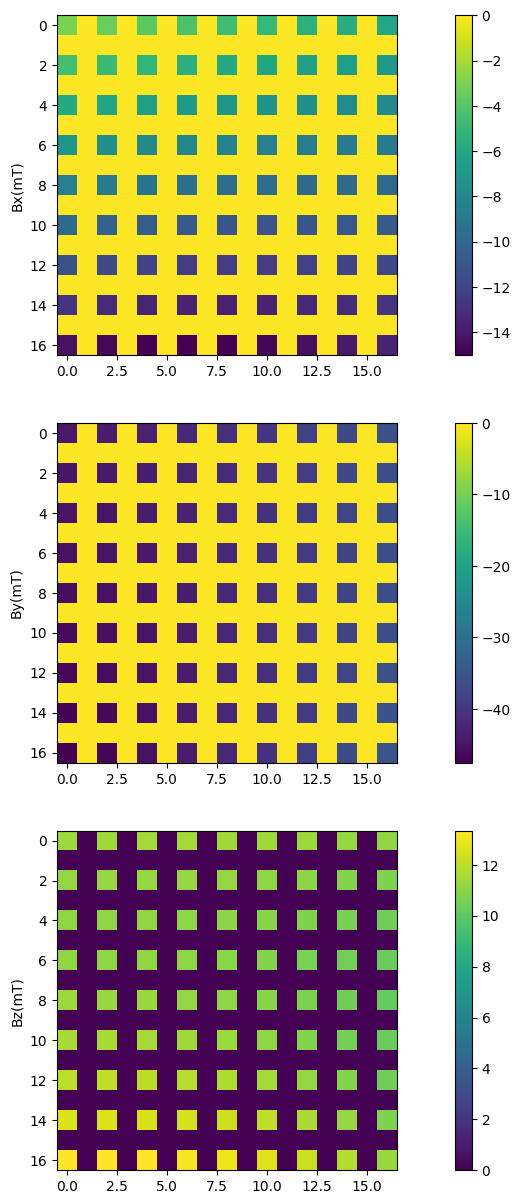

In [24]:
f = plt.figure(figsize=(15,15))

B=torch.zeros(3,17,17,17)



for i in range(0,9):
    for j in range(0,9):
        for k in range(0,9):
            B[:,2*i,2*j,2*k]=centers_y[:,i,j,k]



for i in range(1,4):
    B_est_temp =B[i-1,:,:,z_plane_index]*1e3
    ax = f.add_subplot(3,1,i)
    img_plot = ax.imshow( B_est_temp.cpu() )    
    plt.ylabel(ylables[i-1])
    plt.colorbar(img_plot,ax=[ax])
plt.show

In [5]:
for i in range(0,16,2):

    print(i)

0
2
4
6
8
10
12
14
